# Project 3

Florian Michael-Schwarzinger and Dieter Brehm - Project 3 - Fall 2018

A project examining the orbit characteristics of the apollo 11 spacecraft.

In [134]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question: How long can the apollo 11 spacecraft stay in a parking orbit around the earth? Additionally, what is the ideal velocity for the spacecraft to have to stay in a consistent parking orbit?

Before starting the path to the moon, Apollo missions entered into  an Earth Parking Orbit (EPO). While in this orbit astronauts had two main opportunities to perform a "lunar injection". After one orbit around the earth, and after about 3. We want to examine what characteristics of this situation and see how ship velocity can be optimized for the situation.

## Model

We will model this situation by considering the spacecraft to be a point mass and the earth to be a point in space with a mass and radius. From there, we apply differential equations including the law of universal gravitation given as:

$$dVdt = G \times \frac{M_{earth} \times M_{ship}}{Position^{2}}$$  
  
and  
$$dYdt = Vector(vx, vy)$$

The schematic for this system is: 

![Diagram](Diagram.jpg)

In [135]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

First, we need to define a number of parameters which will describe our system. Namely, the radius and mass of the earth, the mass of the apollo spacecraft, the gravitational constant, and the ideal earth parking orbit (EPO) altitude.

In [136]:
r_earth = 6.3781e6
epo = 190756
r_0 = r_earth + epo

param = Params(r_earth = 6.3781e6 * m,
                epo = 190756 * m,
                r_0 = r_earth + epo,
                x0 = r_0,
                y0 = 0 * m,
                vx0 = 0 * m / s,
                vy0 = -7792 * m / s,
                G=6.674e-11 * N / kg**2 * m**2,
                m_earth=5.972e24 * kg,
                m_apollo=13284 * kg,
                t_0=0 * s,
                t_end=100000 * s)

,values
r_earth,6378100.0 meter
epo,190756 meter
r_0,6.56886e+06
x0,6.56886e+06
y0,0 meter
vx0,0.0 meter / second
vy0,-7792.0 meter / second
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_earth,5.972e+24 kilogram
m_apollo,13284 kilogram


In [137]:
def make_system(params):
    """Make a system object.
    
    params: Params object with r_earth, epo, r_0, x0, y0,
                vx0, vy0, G, m_earth, m_apollo, t_0, t_end
               
    returns: System object
    """
    
    unpack(params)
    
    init = State(x = x0,
                 y = y0,
                 vx = vx0,
                 vy = vy0)
    
    sys = System(init=init,
                 G=G,
                 m_earth=m_earth,
                 m_apollo=m_apollo,
                 t_0=t_0,
                 t_end=t_end)
    return sys

system = make_system(param)

,values
init,x 6.56886e+06 y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_earth,5.972e+24 kilogram
m_apollo,13284 kilogram
t_0,0 second
t_end,100000 second


In [138]:
def universal_gravitation(state, system):
    """Computes gravitational force in our system.
    
    state: State object with distance r
    system: System object with m_earth, m_apollo, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    pos = Vector(x, y)
    
    Fx, Fy = pol2cart(pos.angle, G * m_earth * m_apollo / pos.mag **2) 
    
    force = Vector(Fx, Fy)
    
    return force

In [176]:
# Test our gravitation function to see if it seem reasonable.
universal_gravitation(system[0], system)

<Quantity([122703.05769108      0.        ], 'newton')>

Here, we define our slope function to perform the calculations for our mathematical equations.

In [140]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)

    acc_grav = universal_gravitation(state, system) / m_apollo

    dydt = Vector(vx, vy)
    dvdt = -acc_grav
    
    return dydt.x, dydt.y, dvdt.x, dvdt.y

In [141]:
# Always test the slope function!
slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(-7792.0, 'meter / second')>,
 <Quantity(-9.236905878581915, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [142]:
# make an event function to stop the simulation when the
# apollo module crashes into the earth

def event_func(state, t, system):
    """Error function used to stop the simulation when the
        spacecraft crashes into the earth.
    
    state object: 
    current timestamp: 
    system object:
               
    returns: num that is 0 when crash occurs
    """
    x, y, vx, vy = state
    pos = Vector(x, y)
    return pos.mag - r_earth

In [143]:
event_func(init, 0, system)

<Quantity(190756.0, 'meter')>

In [144]:
# Finally we can run the simulation
system = make_system(param)
results, details = run_ode_solver(system, slope_func, events=event_func)

In [145]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(3467.7598572684724, 'second')>

In [146]:
# ... expressed in units we understand

t_final.to(UNITS.hour)

<Quantity(0.9632666270190201, 'hour')>

In [103]:
# Before plotting, we run the simulation again with `t_eval`
ts = linspace(t_0, t_final, 1000)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

In [104]:
def run_simulation():
    """Wrapper to run the simulation.
               
    returns: results in a Timeframe object
    """
        
    r_earth = 6.3781e6
    epo = 190756

    r_0 = (r_earth + epo)

    init = State(x = r_0 * m,
                 y = 0 * m,
                 vx = 0 * m / s,
                 vy = 7792 * m / s)
    
    system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=5.972e24 * kg,
                m2=292865 * kg,
                t_0=0 * s,
                t_end=100000 * s)
    
    results, details = run_ode_solver(system, slope_func, events=event_func)
    t_final = get_last_label(results) * s
    t_final.to(UNITS.hour)
    
    ts = linspace(t_0, t_final, 1000)
    results, details = run_ode_solver(system, 
                                      slope_func,
                                      events=event_func,
                                      t_eval=ts)
    
    return results

In [105]:
# find altitude over time
def get_alt(results):
    """Given a valid results TimeFrame, assemble a series of altitude values
    
    velocity: the initial velocity of the spacecraft in meters
    
               
    returns: TimeSeries
    """
    alt_tracker = TimeSeries()

    for index, row in results.iterrows():
        alt_tracker[index] = (Vector(row['x'], row['y']).mag - 6.3781e6)

    return alt_tracker

In [115]:
#wrap this plotting into a function
def plot_orbit(simulation_results, earth, potential_path):
    """Pretty plot the results of the simulation.
    
    simulation_results: Timeframe object that is the result of the simulation
    earth: bool, whether or not you want to draw the earth in the plot
    potential_path: bool, whether or not you want to keep running the simulation
        in a second stage after the ship crashes into the earth to see what would
        have happened
               
    returns: tuple of two matplotlib figure objects
    """
    x = simulation_results.x / 1000
    y = simulation_results.y / 1000

    
    # plot x and y versus time of the simulation
    # to show movement trends
    fig1 = plt.figure(figsize=(4, 4))
    ax1 = fig1.add_subplot(211)
    ax1.plot(results.index / 60 / 60, x, label='x')
    ax1.plot(results.index / 60 / 60, y, label='y')
    ax1.set_ylabel("Position (km)")
    ax1.set_xlabel("Time (hours)")
    ax1.legend(["x", "y"])
    ax1.set_title("Distance of apollo module from center of earth");
    
    # plot x vs. y to show movement of the spacecraft
    fig2 = plt.figure(figsize=(4, 8))
    ax1 = fig2.add_subplot(211)
    ax1.plot(x, y, "r")
    ax1.set_ylabel("Y Position (km)")
    ax1.set_xlabel("X Position (km)")
    ax1.set_title("X and Y position of Apollo 11")
    
    # add a circle to represent the earth
    # the plot function didn't like using r_earth
    if earth == True:
        circle1 = plt.Circle((0, 0), radius=6.3781e6 / 1000, color='b')
        ax1.add_artist(circle1)
    
    # plot altitude versus time to show change in alt over time
    fig3 = plt.figure(figsize=(6, 8))
    ax1 = fig3.add_subplot(211)
    ax1.plot(simulation_results.index / 60 / 60, get_alt(simulation_results) / 1000, label="altitude")
    ax1.set_ylabel("Altitude (km)")
    ax1.set_xlabel("Time (hrs)")
    ax1.set_title("Altiude Versus Time of Apollo 11")
    
    
    return fig1, fig2, fig3

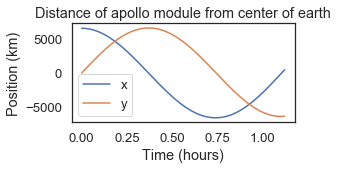

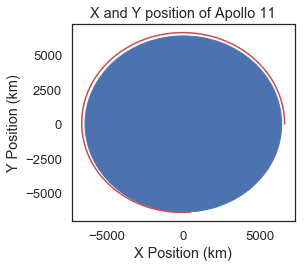

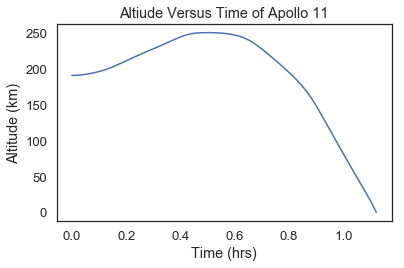

In [116]:
#results_blah = run_simulation()
plot1, plot2, plot3 = plot_orbit(results, True, True)

### Model Assumptions

We chose to make several assumptions during the development of our model. Firstly, we didn't consider drag during any part of the simulation. We chose to make this assumption because we are not concerned with the specifics of the crash event. Secondly, we are also not concerned with the launching of the rocket, instead choosing to start the simulation with the spacecraft with an initial velocity. 

## Optimization - Mean Altitude Error
Here we will try to optimize the craft's velocity in order to get as clean and sustainable EPO as possible. I.E an orbit which keeps the spacecraft as close to the ideal EPO orbit as possible
  
We will optimize for consistent altitude and see if that does the job.


In [117]:
# fresh params object to set up the system for optimization
param = Params(r_earth = 6.3781e6 * m,
                epo = 190756 * m,
                r_0 = r_earth + epo,
                x0 = r_0,
                y0 = 0 * m,
                vx0 = 0 * m / s,
                vy0 = -7792 * m / s,
                G=6.674e-11 * N / kg**2 * m**2,
                m_earth=5.972e24 * kg,
                m_apollo=13284 * kg,
                t_0=0 * s,
                t_end=100000 * s)

,values
r_earth,6378100.0 meter
epo,190756 meter
r_0,6.56886e+06
x0,6.56886e+06
y0,0 meter
vx0,0.0 meter / second
vy0,-7792.0 meter / second
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_earth,5.972e+24 kilogram
m_apollo,13284 kilogram


In [118]:
def run_velocity_varied(velocity, param):
    """Run the simulation with a specified initial velocity.
    
    velocity: the initial velocity of the spacecraft in meters
    params: Params object with r_earth, epo, r_0, x0, y0,
                vx0, vy0, G, m_earth, m_apollo, t_0, t_end
               
    returns: results TimeFrame
    """
    
    params = Params(param, vy0=velocity)
    
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    t_final = get_last_label(results) * s
    t_final.to(UNITS.hour)
    
    ts = linspace(t_0, t_final, 1000)
    results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)
    return results

In [119]:
def error_func(velocity, params):
    """error function that seeks to optimize for ideal altitude
    
    velocity: the initial velocity of the spacecraft in meters
    params: Params object with r_earth, epo, r_0, x0, y0,
                vx0, vy0, G, m_earth, m_apollo, t_0, t_end
               
    returns: difference from ideal epo altitude
    """

    results = run_velocity_varied(velocity, params)
    alt_series = get_alt(results)
    mean_epo = alt_series.mean()

    return mean_epo - 190756

In [120]:
guess = 7792
params_nodim = remove_units(param)
error_func(guess, params_nodim)

<class 'modsim.Params'>


-51462.66194474272

In [121]:
res = fsolve(error_func, guess, params_nodim)

array([7827.4953115])

In [122]:
ideal_velocity = res[0]

7827.495311499185

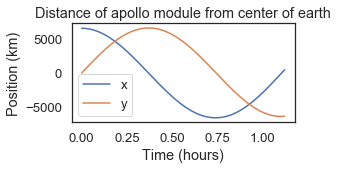

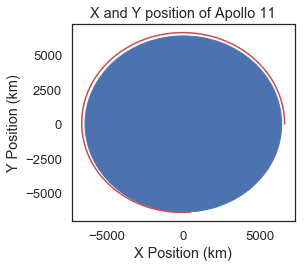

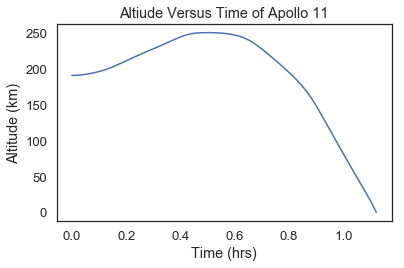

In [123]:
results = run_velocity_varied(ideal_velocity, params_nodim)
plot1, plot2, plot3 = plot_orbit(results, True, True)

### Result of velocity optimization based on altitude

By only optimizing for consistency with the ideal epo altitude, we find the best possible velocity for consistency but not for runtime before a crash. Thus, this optimization doesn't result in the most useful outcome for astronauts. The calculated ideal velocity for this optimization is 7827 m/s.

## Optimization - Rotation maximization 

Now we will run an optimization that seeks to find what velocity is needed for the spacecraft to complete four revolutions around the earth.

In [125]:
# fresh params object to set up the system for optimization
param = Params(r_earth = 6.3781e6 * m,
                epo = 190756 * m,
                r_0 = r_earth + epo,
                x0 = r_0,
                y0 = 0 * m,
                vx0 = 0 * m / s,
                vy0 = -7792 * m / s,
                G=6.674e-11 * N / kg**2 * m**2,
                m_earth=5.972e24 * kg,
                m_apollo=13284 * kg,
                t_0=0 * s,
                t_end=100000 * s)

,values
r_earth,6378100.0 meter
epo,190756 meter
r_0,6.56886e+06
x0,6.56886e+06
y0,0 meter
vx0,0.0 meter / second
vy0,-7792.0 meter / second
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m_earth,5.972e+24 kilogram
m_apollo,13284 kilogram


In order to optimize for revolutions, we need to be able to count how many revolutions have occured.

In [ ]:
def revs(results):
    lead = True
    follow = True
    count = 0
    for i in results.y:
        follow = lead
        lead = i
        if lead >= 0 and follow < 0:
            count += 1           
#    vector = Vector(results_blah.tail(1).x.values[0], results_blah.tail(1).y.values[0])
#    angle = vector.angle * 180/pi
#    if angle < 0:
#        angle = angle + 360
#    decimal = angle/360
    return count

Now, let's try the revolution counter for a single velocity to see if it works

0

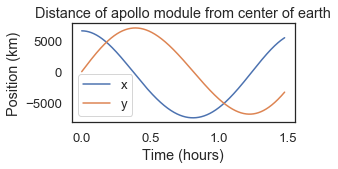

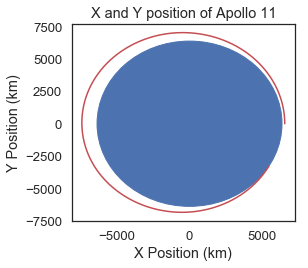

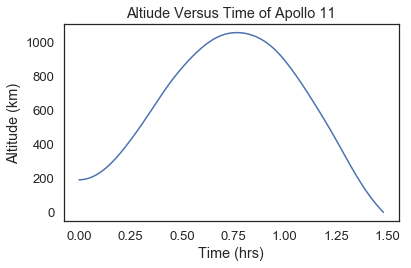

In [151]:
results = run_velocity_varied(8060, param);
plot1, plot2, plot3 = plot_orbit(results, True, True)
revs(results)

Finally, let's sweep through a number of velocities to see where the first viable velocity is in order to get 5 revolutions.

In [155]:
sweep = SweepSeries() #8000 - 9700
for i in linrange(8000, 9000, 10):
    results = run_velocity_varied(i, param);
    sweep[i] = revs(results)

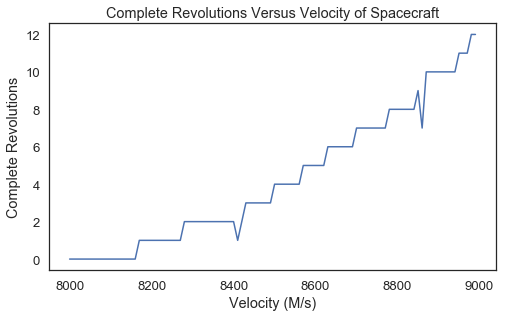

In [174]:
fig4 = plt.figure(figsize=(8, 10))
ax1 = fig4.add_subplot(211)
ax1.plot(sweep)
ax1.set_ylabel("Complete Revolutions")
ax1.set_xlabel("Velocity (M/s)")
ax1.set_title("Complete Revolutions Versus Velocity of Spacecraft");

## Results


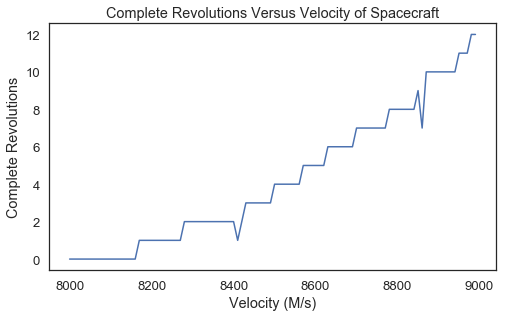

In [175]:
fig4

### Result of velocity optimization based on rotations

The result of this optimization is that 8570 m/s is the slowest velocity where five complete revolutations occur. The plot above shows the progression of revolutions given different velocities.

For the other aspect of our question, the parameters given by the apollo mission report failed to complete one revolution in our model. Thus, while we think many aspects of our modeling process are successful, more tuning is required as this is not a reasonable result.

## Interpretation

As shown by our plot, a velocity of 8570 m/s would result in an orbit which can be sustained for 5 revolutions. This is fairly reasonable relative to what speeds are indicated in official mission reports.  
  
Next steps in this project could include exploring slingshot orbits, performing granular sweeps of velocities for more accurate minimum viable velocities, and recording partial revolutions.

Iteration played a major role in this project. During the development process, we attempted several different optimization processes in order to find one which accomplished what we wanted. In the end, optimizing based on revolutions seemed to be the most reasonable.